[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ecotrust/TreeForCaSt/blob/main/notebooks/Tutorial%202%20-%20Predicting%20Aboveground%20Biomass.ipynb)

# Using TreeForCaSt to predict Aboveground Biomass
This notebook demonstrates how to load data from TreeForCaSt and run a simple U-Net regression model to predict aboveground biomass. 

This workflow assumes you have already have downloaded a local catalog as demonstrated in the notebook [Tutorial 1 - Exploring TreeForCaSt STAC](./Tutorial%201%20-%20Exploring%20TreeForCaSt%20STAC.ipynb).




## Install and import required libraries
If you are running this notebook in Google Colab, uncomment and execute the following cell to install a few packages including some helper functions we've written.

In [1]:
# %pip install pystac rasterio torchmetrics wget git+https://github.com/Ecotrust/treeforcast.git --quiet

In [2]:
from typing import Callable, Optional, List, Dict
import os

import numpy as np
import pandas as pd
import geopandas as gpd

from urllib.request import urlretrieve
from io import BytesIO
from zipfile import ZipFile

# import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import crop
from torchmetrics import R2Score

from pystac import Catalog, Item, Collection
import rasterio
from rasterio.enums import Resampling
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from src.explore import get_item_assets
from src.models import UNet

Download sample catalog

In [4]:
URL = "https://fbstac-stands.s3.amazonaws.com/plots/sandbox/sample_stac.zip"
if not os.path.exists("sample_stac.zip"):
    urlretrieve(URL, "sample_stac.zip")
if not os.path.exists("../../stac/catalog"):
    with ZipFile("sample_stac.zip", "r") as zip:
        zip.extractall("../../")

## Generate training and testing collections

For this example, we will work with the data loaded in the previous tutorial [Tutorial 1 - Exploring TreeForCaSt STAC](./Tutorial%201%20-%20Exploring%20TreeForCaSt%20STAC.ipynb). This local catalog contain the plot collection `usfs-blue-mountains-plots` with 280 individual plots. We will extract all plot items and generate two new collections with data for training and testing out U-Net regression model.

Load catalog and extract items from the plot collection.

In [5]:
catalog = Catalog.from_file("../../stac/catalog/catalog.json")

print("Collections:")
datasets_collection_ids = []
for fplots in catalog.get_collections():
    is_plot = fplots.id.endswith("plots")
    if not is_plot:
        datasets_collection_ids.append(fplots.id)
        print(f"- {fplots.id}")
    else:
        print(f"- {fplots.id} (plot collection)")

Collections:
- usfs-blue-mountains-plots (plot collection)
- 3dep
- naip
- lidar-rast
- 3dep-dtm
- landsat8
- lidar


In [6]:
fplots = catalog.get_child("usfs-blue-mountains-plots")

In [7]:
# Takes a while to run if querying the catalog from AWS S3
items = list(fplots.get_items())
print(f"Number of items: {len(items)}")

Number of items: 280


Inspect item assets

In [8]:
item = items[0]

In [9]:
item_assets = get_item_assets(item)

for a in item_assets:
    print(a.collection_id)

3dep
naip
lidar-rast
3dep-dtm
landsat8
lidar


Split plot items into training and testing lists

In [10]:
train, test = train_test_split(items, test_size=0.2, random_state=42)

print("Plot items for training:", len(train), "\nPlot items for testing:", len(test))

Plot items for training: 224 
Plot items for testing: 56


In [11]:
train[0].geometry["features"]

[{'id': '0',
  'type': 'Feature',
  'properties': {'uuid': '07169c43',
   'tpa': 4.0,
   'ba': 4.0,
   'sdi': 7.0,
   'ccf': 4.0,
   'qmd': 13.984963818473812,
   'tcuft': 129.0,
   'topht': 76.0,
   'number_of_strata': 0.0,
   'total_cover': 2.0,
   'structure_class': '0=BG',
   'canopy_baseheight': 15.0,
   'canopy_bulkdensity': 0.0024912,
   'aboveground_biomass': 2.0,
   'aboveground_carbon': 1.0,
   'aboveground_live_carbon': 1.0,
   'gs_tpa': 4.0,
   'plot_radius': 58.9},
  'geometry': {'type': 'MultiPolygon',
   'coordinates': [[[[-118.46874605333832, 44.6696508619224],
      [-118.46874605333832, 44.67073079992114],
      [-118.47025944191545, 44.67073079992114],
      [-118.47025944191545, 44.6696508619224],
      [-118.46874605333832, 44.6696508619224]]],
    [[[-118.4692763356416, 44.67019374537314],
      [-118.4692770257034, 44.67017789518357],
      [-118.46927988958991, 44.67016216958261],
      [-118.46928489971852, 44.67014672001624],
      [-118.46929200783738, 44.670

Create training and testing collections using `usfs-blue-mountains-plots` as a template.

In [12]:
train_plots = fplots.clone()
train_plots.id = train_plots.id + "-train"
train_plots.clear_items()
train_plots.add_items(train)
train_plots.update_extent_from_items()

test_plots = fplots.clone()
test_plots.id = test_plots.id + "-test"
test_plots.clear_items()
test_plots.add_items(test)
test_plots.update_extent_from_items()

In [13]:
train_plots.id

'usfs-blue-mountains-plots-train'

## Define the dataset class

We define a dataset class that takes a plot collection. For each plot item, the dataset class will load the linked assets and return a dictionary with the target, input image, and a mask with no-data values. 

In this example, we will use Above Ground Biomass (AGB) as the target variable. AGB data is stored as an attribute in the plot feature. AGB values indicate the total biomass per plot in units of Mg/acre. Since we want to predict biomass per pixel, we need a way to distribute the biomass estimate across the pixels in the plot. The Canopy Height Model (CHM) can be useful in this regard. The CHM is a raster image that indicates the height of the tallest tree in each pixel. We can use the CHM to distribute the biomass value across the pixels in the plot using the following formula:

$$ \text{AGB}_{\text{pixel}} = \text{AGB}_{\text{plot}} \times \frac{\text{CHM}_{\text{pixel}}}{\text{CHM}_{\text{plot}}} $$

where $\text{CHM}_{\text{plot}}$ is the sum of the CHM values for all pixels in the plot. 

The input data consist of a stack of image assets. We can select which image assets to include in the input images by passing a dictionary with the asset collection id as the key and a list of the image bands as the value `{collection_id: [band1, band2, ...]}`. To keep the model simple, we use only NAIP imagery for this example. 

The mask with no-data values is generated from the CHM. We will use this mask to ignore pixels with no-data values during training.

In [19]:
def circle_mask(r: int, size: tuple):
    # Create an array filled with zeros
    image = np.zeros(size)

    # Define the parameters of the circle
    center = tuple(i / 2 for i in size)

    # Create the circle
    y, x = np.ogrid[: size[0], : size[1]]
    mask = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r**2
    image[mask] = 1

    return image


class FSTACDataset(Dataset):
    def __init__(
        self,
        collection: Collection,
        use_bands: Dict[str, List[str]],
        use_target: str,
        size: int = 256,
        transform: Optional[Callable] = None,
    ) -> None:
        """
        Args:
            collection: STAC collection to use
            use_bands: Dictionary of collection IDs and bands to use
            use_target: Collection ID of target data
            size: Size of the output image
            transform: Optional transform to be applied on a sample.
        """
        super().__init__()
        self.collection = collection
        self.items = list(collection.get_items())
        self.transform = transform
        self.size = size
        self.use_bands = use_bands
        self.use_target = use_target
        self.input_layers = list(use_bands.keys())

    def __getitem__(self, index):
        sample = {}
        item = self.items[index]
        # Read plot attributes
        item_attrs = gpd.GeoDataFrame.from_features(item.geometry["features"])

        # Load asset that will be used as target
        assets_tgt = [
            a for a in get_item_assets(item) if a.collection_id in self.use_target
        ]

        # Pre-process target 
        with rasterio.open(assets_tgt[0].assets["image"].href) as src:
            target = src.read(
                1,
                out_shape=(self.size, self.size),
                resampling=Resampling.bilinear,
            )
            mask = torch.ones(target.shape)
            # Convert plot radius from feet -> meters -> pixels
            r = (item_attrs.plot_radius.item() * 0.3048) / (240 / self.size * 0.5)
            cmask = circle_mask(r, (self.size, self.size))
            # Set small heights to zero
            target[target < 1] = 0
            target = target * cmask
            target = 100 * item_attrs.aboveground_biomass.item() * target / target.sum()

        # mask[mask == src.nodata] = 0
        mask = torch.FloatTensor(cmask).unsqueeze(0)
        sample["mask"] = mask
        target = torch.FloatTensor(target).unsqueeze(0)
        sample["target"] = target

        # Load assets that will be used as input
        assets = [
            a for a in get_item_assets(item) if a.collection_id in self.input_layers
        ]

        # Pre-process input images
        images = []
        for asset in assets:
            href = asset.assets["image"].href
            with rasterio.open(href) as src:

                bands = self.use_bands[asset.collection_id]
                count = len(bands)

                data = src.read(
                    bands,
                    out_shape=(count, self.size, self.size),
                    resampling=Resampling.bilinear,
                )
                data[data == src.nodata] = 0

                images.append(data)

        image = torch.FloatTensor(np.vstack(images))

        if self.transform:
            image = self.transform(image)
        sample["image"] = image

        return sample

    def __len__(self) -> int:
        return len(self.items)

We will use normalization to transform the input images to the same scale. We use our dataset class to load all image assets in the `usfs-blue-mountains-plots` plot collection and compute their mean and standard deviation. 

In [15]:
use_bands = {
    "naip": [1, 2, 3, 4],
}

In [21]:
plots_dts = FSTACDataset(fplots, use_bands=use_bands, use_target="lidar-rast")
len(plots_dts)

280

Compute the mean and standard deviation for all assets in the plot collection

In [22]:
stats = {"mean": [], "std": []}
for sample in tqdm(plots_dts):
    image = sample["image"].numpy()
    stats["mean"].append(image.mean(axis=(1, 2)))
    stats["std"].append(image.std(axis=(1, 2)))

print(sample["image"].shape)

100%|██████████| 280/280 [00:08<00:00, 33.04it/s]

torch.Size([4, 256, 256])


In [23]:
means = np.array(stats["mean"]).mean(axis=0)
stds = np.array(stats["std"]).mean(axis=0)
means, stds

(array([ 93.995255,  97.68961 ,  87.848236, 120.88192 ], dtype=float32),
 array([35.86497 , 29.49758 , 20.342602, 40.488174], dtype=float32))

Load training and testing data and initialize a dataloader for each dataset

In [24]:
normalize = transforms.Normalize(means, stds)
transform = transforms.Compose([normalize])

In [25]:
train_dts = FSTACDataset(
    collection=train_plots,
    use_bands=use_bands,
    use_target="lidar-rast",
    transform=transform,
)

test_dts = FSTACDataset(
    collection=test_plots,
    use_bands=use_bands,
    use_target="lidar-rast",
    transform=transform,
)

In [26]:
train_dataloader = DataLoader(
    train_dts, batch_size=1, shuffle=True, num_workers=2, drop_last=True
)

## Predicting aboveground biomass using UNet regression

We are now ready to train a computer vision model to predict AGB using remote sensing imagery! We will use a simple U-Net regression model that will predict $AGB_{pixel}$. The model returns a single channel image with $AGB_{pixel}$ estimates instead of a classification label as in a segmentation task. 

To train the model, we will use the Mean Squared Error (MSE) loss function and the Adam optimizer with a learning rate of 0.001. We will train the model for 20 epochs with a batch size of 1. We will score the model using $R^2$ score. $R^2$ values range from 0 to 1, with 1 indicating a perfect fit, where predictions = targets.

In [27]:
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(device)
    print("Device set to:", device)

Device set to: cuda:0


Define model and training parameters

In [28]:
model = UNet(4, 1)
model.to(device)
parameters = model.parameters()
optimizer = optim.Adam(parameters, lr=1e-3, weight_decay=12e-4)
criterion = nn.MSELoss(reduction="none")
r2score = R2Score().to(device)

In [29]:
train_losses = []
train_r2 = []
for epoch in range(30):
    loop = tqdm(train_dataloader)
    loss = 0
    r2 = 0
    step = 0
    for batch in loop:
        step += 1
        img = batch["image"].to(device)
        tgt = batch["target"].to(device)
        mask = torch.ones_like(tgt).to(device)
        mask[tgt == 0] = 0

        preds = model(img)
        model.zero_grad()

        tloss = criterion(preds, tgt)
        # Crop prediction to prevent the model from learning the plot shape
        tloss = crop(tloss, 104, 104, 50, 50)
        tloss = torch.mean(tloss)
        tloss.backward()
        optimizer.step()

        loss += tloss.item()

        r2 += r2score((preds * mask).flatten(), tgt.flatten()).item()

        loop.set_postfix(loss=f"{loss/step:.5f}", r2=f"{r2/step:.3f}")
        # break

    # store loss for plotting
    train_losses.append(loss/step)
    train_r2.append(r2/step)
    # break

100%|██████████| 224/224 [00:08<00:00, 27.07it/s, loss=0.82483, r2=-0.249]


Plot training loss and $R^2$ score across epochs

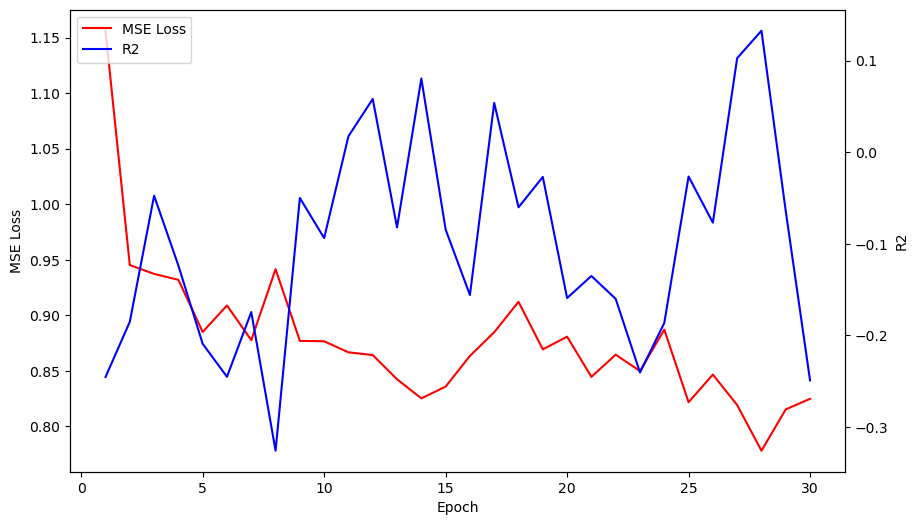

In [30]:
df = pd.DataFrame(
    {"epoch": range(1, len(train_losses) + 1, 1), "loss": train_losses, "r2": train_r2}
)
df["epoch"] = df["epoch"].astype(int)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.epoch, df.loss, label="MSE Loss", color="red")
ax2 = ax.twinx()
ax2.plot(df.epoch, df.r2, label="R2", color="blue")

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.set(xlabel="Epoch", ylabel="MSE Loss")
ax2.set_ylabel("R2")
plt.show()

Despite the small training dataset, the model is able to learn the relationship between the spectral information in the input images and AGB data in the target. Note that the loss decreases with each epoch while the $R^2$ increases.

We can now visualize how well our model performs on the testing dataset. 

Define a function to de-normalize images for visualization

In [31]:
inverse_transform = transforms.Compose(
    [
        transforms.Normalize(mean=0, std=1 / stds),
        transforms.Normalize(mean=-1 * means, std=1),
    ]
)

Test trained model on the test collection

Model score (R^2): 0.47747665643692017


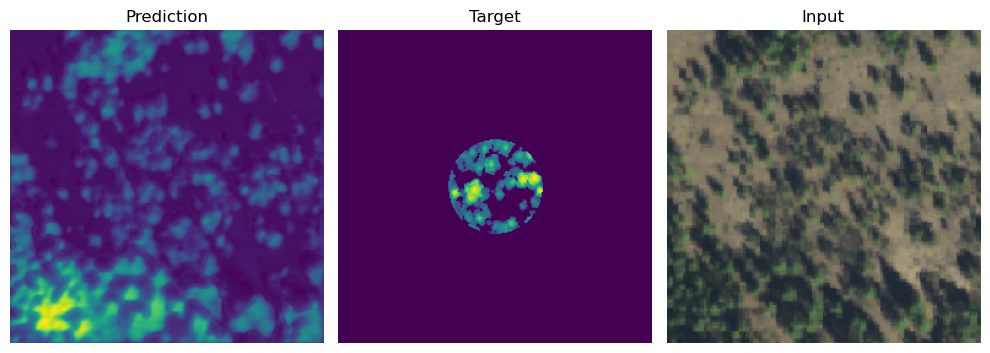

Model score (R^2): 0.6383532881736755


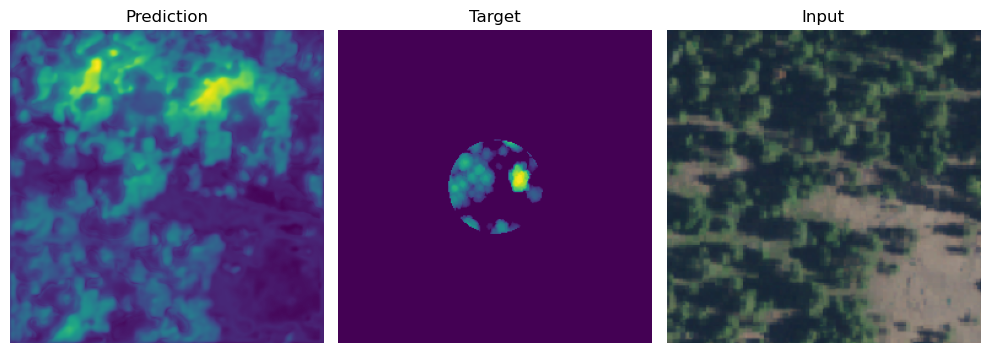

Model score (R^2): 0.7545442581176758


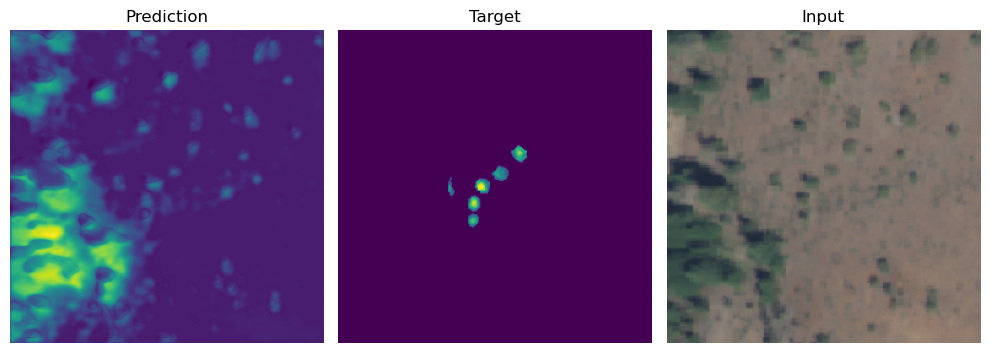

Model score (R^2): 0.5383142232894897


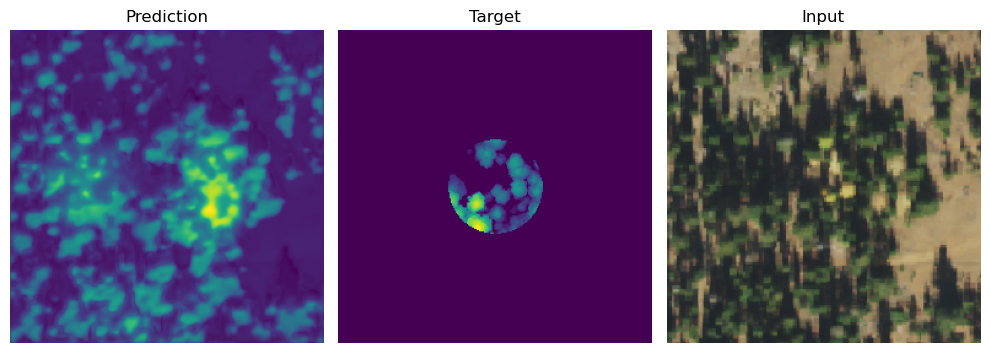

Model score (R^2): -0.6373227834701538


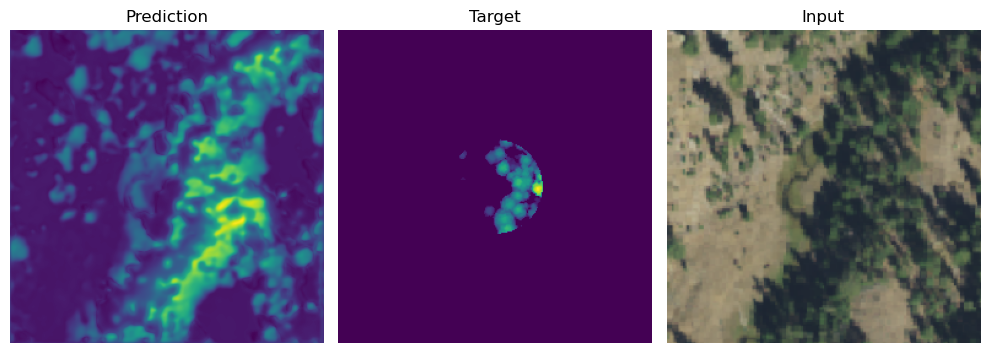

Model score (R^2): 0.4552731513977051


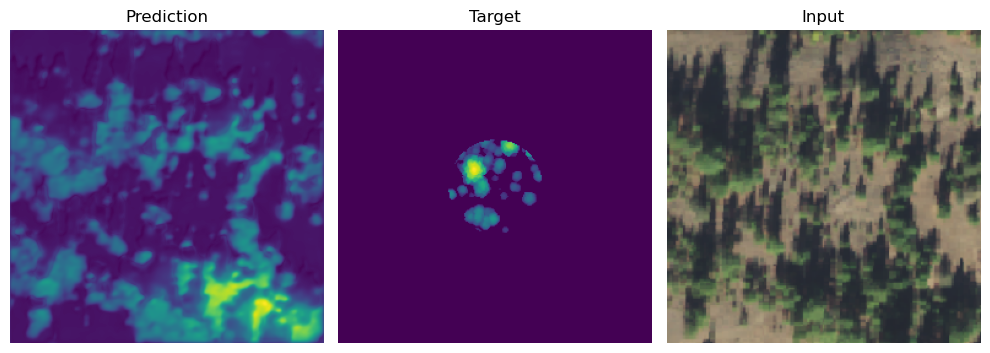

Model score (R^2): 0.6902875900268555


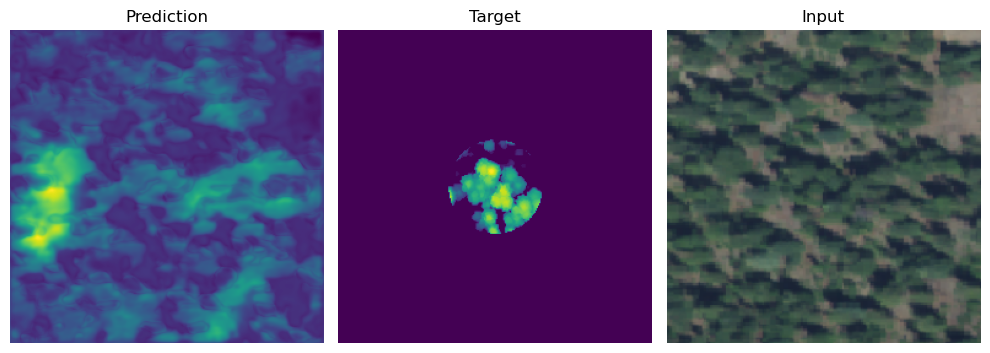

In [32]:
idx = 0
with torch.no_grad():
    for sample in test_dts:
        img = sample["image"].to(device)
        tgt = sample["target"].to(device)
        mask = torch.ones_like(tgt).to(device)
        mask[tgt == 0] = 0

        pred = model(img.unsqueeze(0))
        prediction = pred.cpu().squeeze().numpy()
        target = tgt.cpu().squeeze().numpy()
        inputs = np.transpose(
            inverse_transform(img).cpu().squeeze().numpy()[0:3], (1, 2, 0)
        )

        r2 = r2score((pred * mask).flatten(), tgt.flatten()).item()
        print("Model score (R^2):", r2)

        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
        imgs = [prediction, target, inputs]
        axs = axs.ravel()

        for i in range(len(imgs[:2])):
            im = imgs[i]
            im = im.astype(np.float32)
            im = (im - im.min()) / (im.max() - im.min())
            axs[i].imshow(im, cmap="viridis")
            axs[i].axis("off")
            axs[i].set_title(["Prediction", "Target"][i])

        axs[2].imshow(inputs.astype(np.uint8), cmap="viridis")
        axs[2].axis("off")
        axs[2].set_title("Input")

        plt.tight_layout()
        plt.show()

        if idx > 5:
            break
        idx += 1